In [1]:
#%% Imports

import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OrdinalEncoder
import shapely
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

import geopandas as gpd
import rioxarray
import rasterio
import xarray as xr
from geocube.api.core import make_geocube

pd.options.mode.chained_assignment = None  # default='warn'
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from io import BytesIO


In [9]:
#%% Definitions

crs_projection = 'epsg:4326'  # Assuming WGS84 coordinate system

# Correct Name for the districts:
districts = pd.read_csv('districts_names.csv')
districts = districts.set_index('AltName').to_dict()['Name']

def correct_districts(df_district):
    return df_district.replace(districts)

regions = {'Banaadir': 'Banadir'}

def correct_regions(df_region):
    return df_region.replace(regions)

# Load shapefile
path = r''
Somalia_map_district = gpd.read_file('Admin2_Map_UNDP.geojson')
Somalia_map_district.admin2Name = correct_districts(Somalia_map_district.admin2Name)
Somalia_map_district = Somalia_map_district.sort_values(['admin2Name']).reset_index(drop=True)

Somalia_map_district["District"] = Somalia_map_district.admin2Name.index.astype(int)


# 1. Climate cubes


In [7]:
#%% Read Climate raster

path_cube = 'UC2_Climate_Cube.nc'

era5 = xr.open_dataset(path_cube)
era5.rio.write_crs(crs_projection, inplace=True)

# Clip to Somalia
UC2_cube = era5.rio.clip(Somalia_map_district.geometry.values, Somalia_map_district.crs)

# Transpose the variables
UC2_cube = UC2_cube.transpose('latitude', 'longitude', 'time')
UC2_cube = UC2_cube.sortby(['latitude', 'longitude','time']) 

del era5

UC2_cube

<xarray.Dataset>
Dimensions:      (longitude: 104, latitude: 136, time: 8710)
Coordinates:
  * longitude    (longitude) float32 41.0 41.1 41.2 41.3 ... 51.0 51.1 51.2 51.3
  * latitude     (latitude) float32 -1.6 -1.5 -1.4 -1.3 ... 11.6 11.7 11.8 11.9
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2023-11-05
    spatial_ref  int32 0
Data variables:
    t2m          (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    pev          (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl1        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl2        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl3        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl4        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    precip       (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    lccs_class   (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    SPEI_6M      (latitude, longitude, time) float64 nan nan nan ... nan nan nan

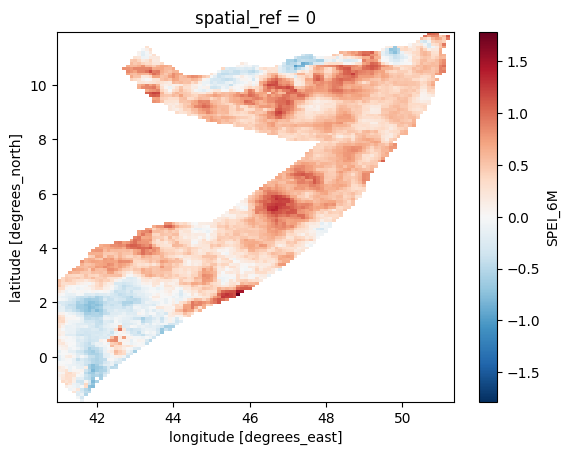

In [5]:
UC2_cube['SPEI_6M'].sel(time='2016').mean(dim = ['time']).plot()

### 1.1 Aggregate Shapefiles



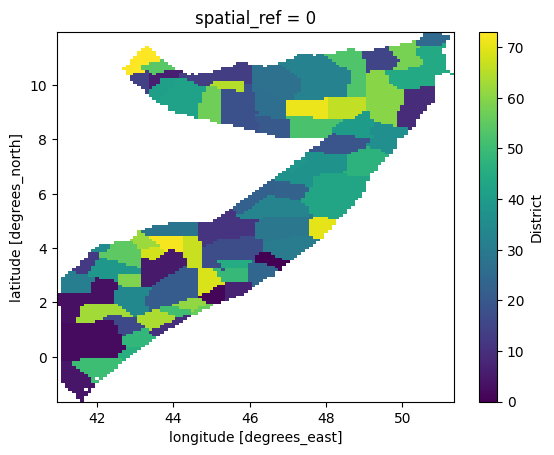

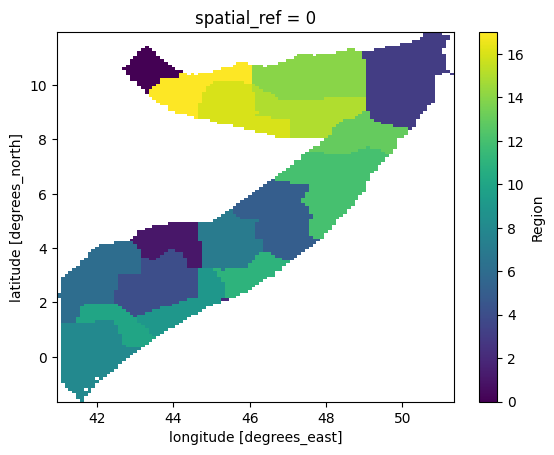

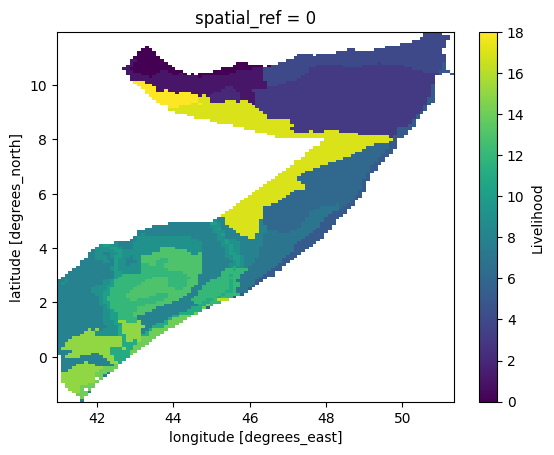

In [8]:
# Aggregate District
district_geom = Somalia_map_district.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
district_geom = make_geocube(vector_data=Somalia_map_district, resolution=(0.01, -0.01), fill=np.NaN)
district_geom = district_geom.rename({'y': 'latitude', 'x': 'longitude'})
district_geom = district_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude, method='nearest')
district_geom['District'].attrs['District_Name'] = Somalia_map_district.admin2Name.to_list()

# # Merge by lat/lon
UC2_cube = xr.merge([district_geom, UC2_cube])
UC2_cube.District.plot()
plt.show()

#%% Add Region shapefile
path_region = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\Shapefiles\Admin1_Map_UNDP.geojson'
Somalia_map_region = gpd.read_file(path_region)
Somalia_map_region = Somalia_map_region[['ADM1_EN', 'geometry']]
Somalia_map_region.ADM1_EN = correct_regions(Somalia_map_region.ADM1_EN)

Somalia_map_region["Region"] = Somalia_map_region.ADM1_EN.index.astype(int)

region_geom = Somalia_map_region.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
region_geom = make_geocube(vector_data=Somalia_map_region, resolution=(0.01, -0.01), fill=np.NaN)
region_geom = region_geom.rename({'y': 'latitude', 'x': 'longitude'})
region_geom = region_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude,  method='nearest')

# Assign the district names as an attribute to the "district" variable
region_geom['Region'].attrs['Region_Name'] = Somalia_map_region.ADM1_EN.to_list()

# Merge by lat/lon
UC2_cube = xr.merge([region_geom, UC2_cube])

UC2_cube.Region.plot()
plt.show()

#%% Add Livelihood Zone Shapefile
path_livel = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\Shapefiles\SO_LHZ_2015.geojson'
Somalia_map_livelihood = gpd.read_file(path_livel)
Somalia_map_livelihood = Somalia_map_livelihood[['LZNUM', 'LZNAMEEN', 'geometry']].drop(columns={'LZNUM'})
Somalia_map_livelihood["Livelihood"] = Somalia_map_livelihood.LZNAMEEN.index.astype(int)

livel_geom = Somalia_map_livelihood.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
livel_geom = make_geocube(vector_data=Somalia_map_livelihood, resolution=(0.01, -0.01), fill=np.NaN)
livel_geom = livel_geom.rename({'y': 'latitude', 'x': 'longitude'})
livel_geom = livel_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude,  method='nearest')

# Assign the district names as an attribute to the "district" variable
livel_geom['Livelihood'].attrs['Livelihood_Name'] = Somalia_map_livelihood.LZNAMEEN.to_list()

# Merge by lat/lon
UC2_cube = xr.merge([livel_geom, UC2_cube])
UC2_cube.Livelihood.plot()
plt.show()

# 2. Socioeconomic Cube

### 2.1 Conflict Cube

In [5]:
#%% Download ACLED datasets

path_ACLED = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\ACLED_df.csv'

def fetch_ACLED_data():

    key = 'upUDWqNGHqRnz4ZDD8mY'
    email = 'jomataha@uv.es'

    params = {
                    "key": key,
                    "email": email,
                    "first_event_date": '2006-01-01',
                    "last_event_date": str(date.today()),
                    "limit":100000000000000, # No limit
                    "country": 'Somalia',
                }

    res = requests.get("https://api.acleddata.com/acled/read", params=params)
    data_json = res.json()['data']
    ACLED_df = pd.json_normalize(data_json)

    print('ACLED data retreived succesfully')
    
    ACLED_df.to_csv(path_ACLED, index  = False)

    return ACLED_df

ACLED_df = fetch_ACLED_data()

ACLED data retreived succesfully


In [10]:
#%% Build Conflict Cube

ACLED_df = pd.read_csv(r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\ACLED_df.csv')

# Clean and format conflict data
ACLED_df = ACLED_df[['fatalities', 'event_date', 'longitude', 'latitude']].rename(columns={'event_date':'time'})

ACLED_df.time = pd.to_datetime(ACLED_df.time)

# Scale to ERA5LAND resolution:
ACLED_df = ACLED_df[(ACLED_df['time'].dt.year >= 2010)].sort_values('time')
ACLED_df['longitude'] = np.round(ACLED_df['longitude'],1)
ACLED_df['latitude'] = np.round(ACLED_df['latitude'],1)

ACLED_df = ACLED_df.groupby(['time', 'longitude', 'latitude']).sum()

acled_xarray = ACLED_df.to_xarray()
acled_xarray = acled_xarray.transpose('latitude', 'longitude', 'time')
acled_xarray = acled_xarray.sortby(['time', 'latitude', 'longitude'])    

acled_xarray = acled_xarray.interp_like(UC2_cube, method= "nearest")

UC2_cube = xr.merge([UC2_cube, acled_xarray])

del acled_xarray

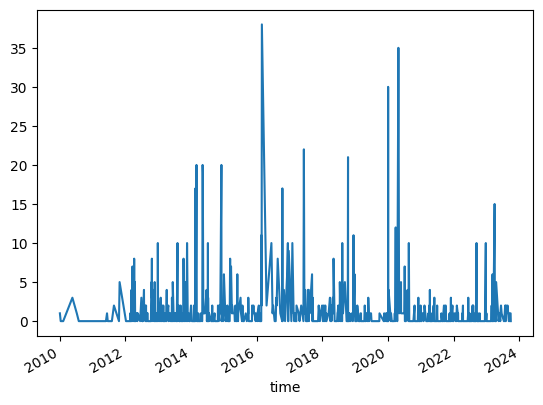

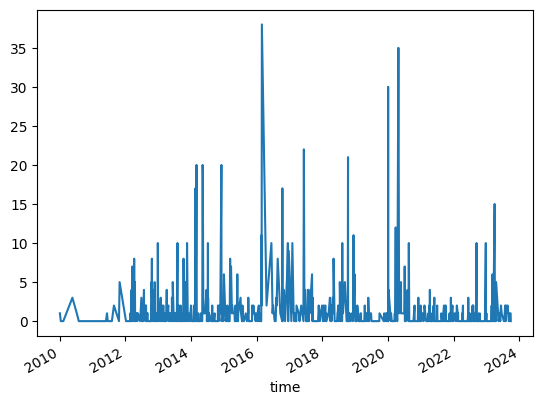

In [6]:
# Plots 4 check:

test = ACLED_df.reset_index()
test[(test.latitude == 3.1) & (test.longitude == 43.6)].set_index('time').fatalities.plot()
plt.show()

# Same result as with ACLED 
UC2_cube['fatalities'].where(UC2_cube.longitude == 43.6, drop=True).where(UC2_cube.latitude == 3.1, drop=True).to_dataframe().dropna().reset_index().set_index('time')['fatalities'].plot()
plt.show()


### 2.2 Displacement Cube

In [11]:
#%% Download PRMN datasets

def collect_PRMN_IDP(url):

    # Collect NEW DATA from PRMN website
    response = requests.get(url)
    if response.status_code == 200:
        data = requests.get(url).content
        PRMN_data = pd.read_excel(BytesIO(data), engine='openpyxl')
        print("PRMN file downloaded successfully.")
    else:
        print("Failed to download the PRMN file.")

    # Convert Year Week to DATE
    PRMN_data['Arrival'] = pd.to_datetime(PRMN_data['Year Week'].astype(str) + '-1', format='%Y%W-%w')

    # Select columns
    PRMN_data.rename(columns = {'Arrival': 'Date', 'Previous (Departure) District': 'District', 'Number of Individuals':'IDP','Previous (Departure) Region': 'Region'}, inplace = True)
    PRMN_data = PRMN_data[['Date', 'Region', 'District', 'Reason', 'IDP']]
    # Drought
    new_drought = PRMN_data[PRMN_data['Reason'] == 'Drought related'].drop('Reason', axis = 1)
    new_drought.rename(columns = {'IDP':'IDP_Drought'}, inplace = True)
    # Conflict
    new_conflict = PRMN_data[PRMN_data['Reason'] == 'Conflict/Insecurity'].drop('Reason', axis = 1)
    new_conflict.rename(columns = {'IDP':'IDP_Conflict'}, inplace = True)

    PRMN_data_IDP = pd.merge(new_drought, new_conflict, on=['Date', 'Region', 'District'], how='outer')

    PRMN_data_IDP.to_csv('PRMN_df.csv', index  = False)

    return PRMN_data_IDP

# Collect Data from github:
url = "https://unhcr.github.io/dataviz-somalia-prmn/data/UNHCR-PRMN-Displacement-Dataset.xlsx"

PRMN_data_IDP = collect_PRMN_IDP(url)


PRMN file downloaded successfully.


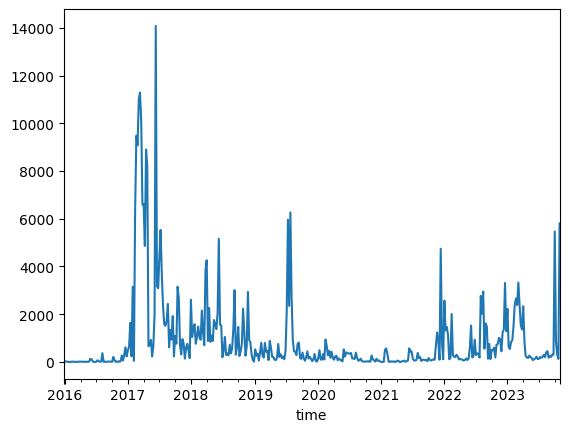

In [12]:
#%% Build Displacement Cube: Aggregation to centroid

PRMN_data_IDP = pd.read_csv('PRMN_df.csv')

# Clean District Names
PRMN_data_IDP.District = correct_districts(PRMN_data_IDP.District)
# Sum repeated index entries 
PRMN_data_IDP = PRMN_data_IDP[['Date','District', 'IDP_Drought', 'IDP_Conflict']].groupby(['Date', 'District']).sum()

PRMN_data_IDP = PRMN_data_IDP.reset_index().sort_values(['District', 'Date']).reset_index(drop=True).rename(columns={'Date':'time'})

PRMN_data_IDP.time = pd.to_datetime(PRMN_data_IDP.time)

PRMN_data_IDP = PRMN_data_IDP[PRMN_data_IDP['District'].isin(Somalia_map_district.admin2Name.unique())]

# Upsample to weekly
PRMN_data_IDP = PRMN_data_IDP.set_index('time').groupby('District').apply(lambda x: x.resample('D').asfreq()).drop(columns = 'District').reset_index().fillna(0)

# Centroid of Districts:
def get_centroid(geometry):
    centroid = geometry.centroid 
    return pd.Series({'latitude': np.round(centroid.y, 1).astype(np.float32), 'longitude': np.round(centroid.x, 1).astype(np.float32)})

Somalia_map_district_centroid = Somalia_map_district.copy()
Somalia_map_district_centroid[['latitude', 'longitude']] = Somalia_map_district_centroid['geometry'].apply(get_centroid)
Somalia_map_district_centroid = Somalia_map_district_centroid.drop(columns=['District']).rename(columns={'admin2Name': 'District'})

PRMN_data_IDP = pd.merge(PRMN_data_IDP, Somalia_map_district_centroid[['latitude',	'longitude', 'District']], on=["District"], how="left")

PRMN_data_IDP = PRMN_data_IDP.set_index(['time', 'longitude', 'latitude'])

# Convert the DataFrame to an xarray Dataset
PRMN_data_IDP_xarray = PRMN_data_IDP[['IDP_Drought', 'IDP_Conflict']].to_xarray()
PRMN_data_IDP_xarray.rio.write_crs(crs_projection, inplace=True)
PRMN_data_IDP_xarray = PRMN_data_IDP_xarray.sortby(['time', 'latitude', 'longitude'])   
PRMN_data_IDP_xarray = PRMN_data_IDP_xarray.transpose('latitude', 'longitude', 'time')

PRMN_data_IDP_xarray = PRMN_data_IDP_xarray.reindex_like(UC2_cube)

UC2_cube = xr.merge([UC2_cube, PRMN_data_IDP_xarray])

# Plot Baidoa Weekly
UC2_cube.where(UC2_cube.District == 5, drop=True).IDP_Drought.to_dataframe().dropna().reset_index().set_index('time').resample('W-MON', label='left', closed = 'left').IDP_Drought.sum().plot()

del PRMN_data_IDP_xarray

### 2.3 Market Cube

In [33]:

test = pd.read_csv(r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\FSNAU Market Data\FSNAU-Market-Data-2023.csv'
)

In [42]:
#%% Load and clean market price data

from Data_Retrieval import fetch_latest_FSNAU_data
from Data_Aggregation_Functions import correct_districts, correct_regions, aggregate_best_market

current_year = date.today().year
years = list(range(2010, current_year + 1))

current_year = '2023'
path = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\FSNAU Market Data\FSNAU-Market-Data-' + current_year + ".csv"
fetch_latest_FSNAU_data(current_year, path)

market_data = pd.DataFrame()

for year in years:
    
    path = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\UC2_Climate_Migrations_in_Africa\Data\Non-EO\FSNAU Market Data\FSNAU-Market-Data-' + str(year) + ".csv"
    market_year = pd.read_csv(path)
    market_year.rename(columns = {'RedSorghum1kg': 'Red Sorghum Price', 'WheatFlour1kg': 'Wheat Flour Price', 'Cowpeas': 'Cowpeas Price',
                             'Sugar': 'Sugar Price', 'TeaLeaves': 'Tea Leaves Price', 'Salt': 'Salt Price', 'VegetableOil1litre': 'Vegetable Oil Price',
                             'GoatLocalQuality': 'Goat Price', 'CattleLocalQuality': 'Cattle Price', 'CamelLocalQuality': 'Camel Price',
                             'FreshCamelMilk1litre': 'Camel Milk Price', 'WaterDrum': 'Water Drum Price', 'WaterDrum200L': 'Water Drum Price'}, inplace=True)
    market_data = pd.concat([market_data, market_year])

market_data.head()

market_data = market_data.sort_values(by = ['Market', 'Year', 'Month']).reset_index(drop=True)
market_data = market_data.dropna(subset= ['Market', 'District', 'Region'])
market_data = market_data.replace('-', np.NaN)
market_data.iloc[:,6:] = market_data.iloc[:,6:].astype(float)

def entitle(string):
    return string.title()

market_data['Region'] = market_data['Region'].apply(entitle)
market_data['District'] = market_data['District'].apply(entitle)
market_data['Market'] = market_data['Market'].apply(entitle)

market_data['Date'] = pd.to_datetime(market_data['Year'].astype(str) + '-' + market_data['Month'])
print(market_data['Date'].max())
market_data['Date'] = market_data['Date'] + timedelta(15)
market_data = market_data.drop(columns = ['Month', 'Year'])

market_data.District = correct_districts(market_data.District)
market_data.Market = correct_districts(market_data.Market)
market_data.Region = correct_regions(market_data.Region)

# Drop features that have few points.
# I drop 50kg vs 1kg because 1kg is better sampled
# I get local quality vs export quality because same dynamics and better sampled

# We sometimes have stepped prices that are constant throghout time (which does not make sense)
# For water we have nice looking prices for water drum and WaterOneJerican20litre independent of the district
# WheatMaize1kg reflects better peaks in drought periods than Flour


features = ['Red Sorghum Price', 'Wheat Flour Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price', 
            'Water Drum Price', 'Cattle Price', 'Camel Price', 'Goat Price', 'SomaliShillingToUSD', 'SomalilandShToUSD']

market_data = market_data[['Date', 'Region', 'District', 'Market'] + features]

# Convert the date column to datetime if it's not already
market_data['Date'] = pd.to_datetime(market_data['Date'])

# Filter out rows with the maximum date of 2016 within each group
market_data = market_data.groupby(['Region', 'District', 'Market']).filter(
    lambda x: x['Date'].max().year != 2016
)

# Append the results of the market geocoding to locate local markets in the map. We retrieved the results in the "Geocoding.ipynb" file
path = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\Somalia\Data Aggregation Final\Geocoding\Market_LAT_LON.csv'

market_geocoding = pd.read_csv(path)
market_geocoding.drop(columns = {'Unnamed: 0', 'Region'}, inplace=True)

# Append LAT LON
market_data_geocoded = pd.merge(market_data, market_geocoding, on=['Market', 'District'])

# # Scale to ERA5LAND resolution:
market_data_geocoded['longitude'] = np.round(market_data_geocoded['longitude'],1)
market_data_geocoded['latitude'] = np.round(market_data_geocoded['latitude'],1)

market_data_geocoded= market_data_geocoded.drop_duplicates()

# Resample monthly to calculate ordinal variance for each market:
market_data_geocoded = market_data_geocoded.groupby(['Region','District','Market', 'latitude', 'longitude']).resample('M', label='left', closed = 'left', on='Date').mean().reset_index(level=['Date', 'Region', 'District', 'Market', 'latitude', 'longitude'])


Login successful. Redirected to the dashboard page.
Successfully accessed the data export page.
Excel data saved successfully.
2023-10-01 00:00:00


In [45]:
# Iterate with same coordinates markets and select the best one (because they are in the same coordinate, town, or very close):

groups = market_data_geocoded.groupby(['latitude', 'longitude'])

final_dataframe = pd.DataFrame()
ord_enc = OrdinalEncoder()

for (lat, lon), group in groups:

        this_zone = group.fillna(0)
        zone_markets = np.unique(this_zone.Market)
                
        if len(zone_markets) > 1:
            print(f"Coordinates ({lat}, {lon}):")
            print(zone_markets)

            # For each group save the best feature column
            best_market_data = this_zone[this_zone['Market'] == zone_markets[0]][['Date', 'Region','District','Market', 'latitude', 'longitude']].reset_index(drop=True)

            # Iterate through the features:
            for feature in this_zone.columns[6:]:
                ord_variance = np.array([])

                # Iterate through markets
                for market in zone_markets:

                    # Select market and ordinal encode values and then calculate variance
                    check_market = this_zone[this_zone['Market'] == market]
                    market_enc = ord_enc.fit_transform(np.unique(np.array(check_market[feature])).reshape(-1, 1)).astype(int)
                    variance = np.var(market_enc.flatten())
                    ord_variance = np.append(ord_variance, variance)

                # Select the feature that has the maximum variance among markets
                max_index = np.argmax(ord_variance)
                market_best_feature = zone_markets[max_index]


                # Append the best feature to the district data
                best_market_feature = this_zone[(this_zone['Market'] == market_best_feature)][feature].reset_index(drop=True)
                best_market_data = pd.concat([best_market_data, best_market_feature], axis=1)

            #     print('selected:', feature, 'in', market_best_feature, 'for:', f"Coordinates ({lat}, {lon}):")
            # print('-------------------------------------------------')
            # Concatenate district data to the final dataframe
            final_dataframe = pd.concat([final_dataframe, best_market_data], axis=0).reset_index(drop=True)
        
        else: 
            final_dataframe = pd.concat([final_dataframe, group], axis=0).reset_index(drop=True)


market_data_clean = final_dataframe.replace(0, np.nan)
market_data_clean = market_data_clean.rename(columns={'Date': 'time'})
market_data_clean = market_data_clean.dropna(subset=['latitude', 'longitude', 'time'])

Coordinates (2.0, 45.3):
['Banadir' 'Mogadishu Bakara' 'Suuq Bacaad']
Coordinates (2.4, 43.0):
['Diinsoor' 'Habaalbalbaar']
Coordinates (3.8, 43.1):
['El Bur' 'El Der']
Coordinates (3.8, 43.2):
['Burdunle' 'Waajid']


In [46]:
# Get the max date in the dataframe
max_date = market_data_clean.time.max()
# Create a date range from '2010' to max_date with daily frequency
date_range = pd.date_range('2010', max_date, freq='D')
# Resample each group by the date range and fill missing values with zeros
market_data_clean = market_data_clean.set_index('time').groupby(['latitude', 'longitude']).apply(lambda x: x.reindex(date_range, fill_value=0)).drop(columns=['latitude', 'longitude']).reset_index()

market_data_clean = market_data_clean.rename(columns={'level_2': 'time'}).set_index(['latitude', 'longitude', 'time'])

market_data_xarray = market_data_clean.iloc[:,3:].to_xarray()

market_data_xarray = market_data_xarray.sortby(['time', 'latitude', 'longitude'])   
market_data_xarray = market_data_xarray.transpose('latitude', 'longitude', 'time')

UC2_cube = UC2_cube.sel(time=slice(PRMN_data_IDP.reset_index().time.min(), PRMN_data_IDP.reset_index().time.max()))
market_data_xarray = market_data_xarray.sel(time=slice(PRMN_data_IDP.reset_index().time.min(), PRMN_data_IDP.reset_index().time.max()))

UC2_cube = xr.merge([UC2_cube, market_data_xarray])

del market_data_xarray


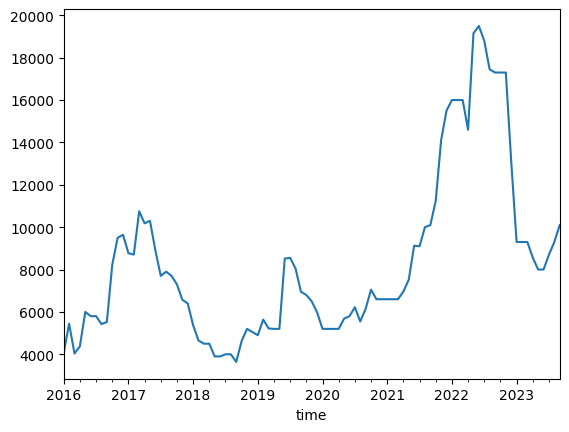

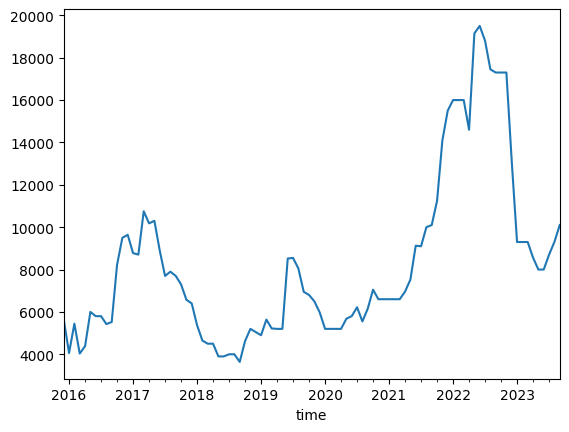

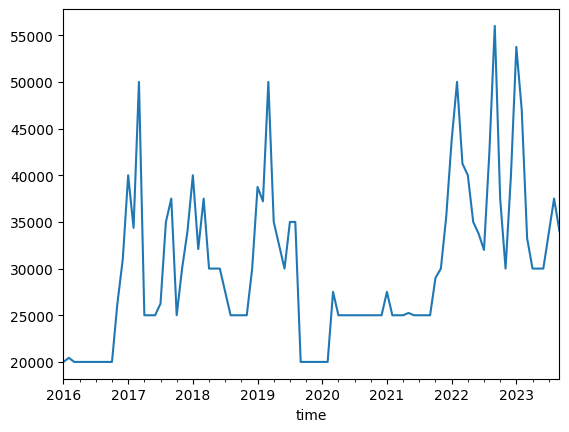

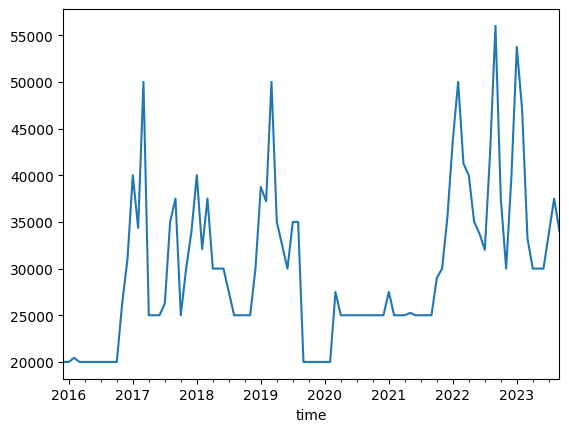

In [47]:
# Plot 4 check

test = market_data_clean.reset_index()[market_data_clean.reset_index().time >= '2016'].sort_values(['longitude','latitude','time'])
test[(test.latitude == 3.1) & (test.longitude == 43.6)].set_index('time')['Red Sorghum Price'].resample('M').sum().plot()
plt.show()

UC2_cube['Red Sorghum Price'].where(UC2_cube.longitude == 43.6, drop=True).where(UC2_cube.latitude == 3.1, drop=True).to_dataframe().dropna().reset_index().set_index('time')['Red Sorghum Price'].resample('M').sum().plot()
plt.show()

test = market_data_clean.reset_index()[market_data_clean.reset_index().time >= '2016'].sort_values(['longitude','latitude','time'])
test[(test.latitude == 3.1) & (test.longitude == 43.6)].set_index('time')['Water Drum Price'].resample('M').sum().plot()
plt.show()

UC2_cube['Water Drum Price'].where(UC2_cube.longitude == 43.6, drop=True).where(UC2_cube.latitude == 3.1, drop=True).to_dataframe().dropna().reset_index().set_index('time')['Water Drum Price'].resample('M').sum().plot()
plt.show()


# Write Cube


In [48]:
UC2_cube = UC2_cube.sel(time=slice('2016',None))
vars_list = list(UC2_cube.data_vars)  
for var in vars_list:  
    if 'grid_mapping' in UC2_cube[var].attrs:
        del UC2_cube[var].attrs['grid_mapping']

UC2_cube.to_netcdf('UC2_public_cube.nc')


# Write Tabular Data

#### District

District ('Banadir',):
['Banadir' 'Mogadishu Bakara' 'Suuq Bacaad']
selected: Red Sorghum Price in Banadir for: Area (('Banadir',)):
selected: Wheat Flour Price in Mogadishu Bakara for: Area (('Banadir',)):
selected: Sugar Price in Banadir for: Area (('Banadir',)):
selected: Vegetable Oil Price in Mogadishu Bakara for: Area (('Banadir',)):
selected: Camel Milk Price in Banadir for: Area (('Banadir',)):
selected: Tea Leaves Price in Mogadishu Bakara for: Area (('Banadir',)):
selected: Salt Price in Suuq Bacaad for: Area (('Banadir',)):
selected: Cowpeas Price in Banadir for: Area (('Banadir',)):
selected: Water Drum Price in Banadir for: Area (('Banadir',)):
selected: Cattle Price in Mogadishu Bakara for: Area (('Banadir',)):
selected: Camel Price in Mogadishu Bakara for: Area (('Banadir',)):
selected: Goat Price in Mogadishu Bakara for: Area (('Banadir',)):
selected: SomaliShillingToUSD in Suuq Bacaad for: Area (('Banadir',)):
selected: SomalilandShToUSD in Banadir for: Area (('Banadir

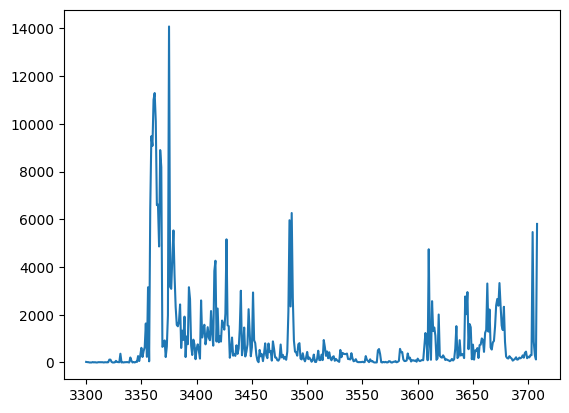

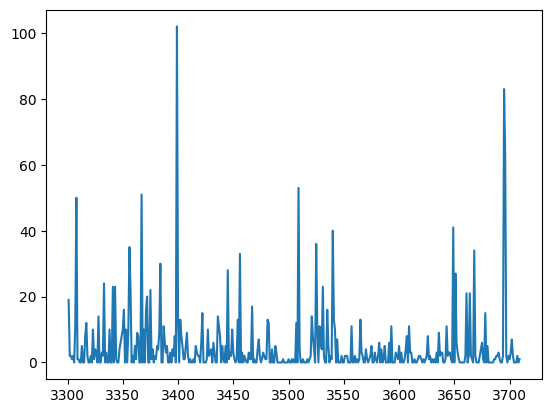

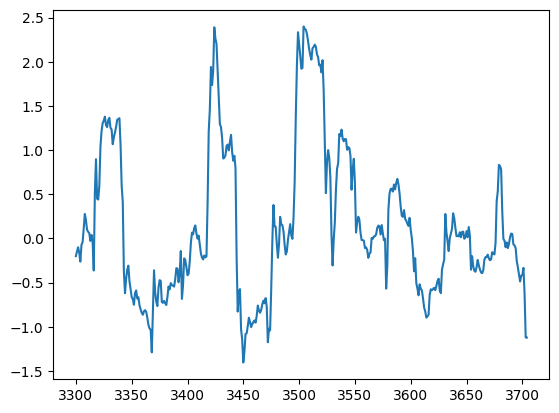

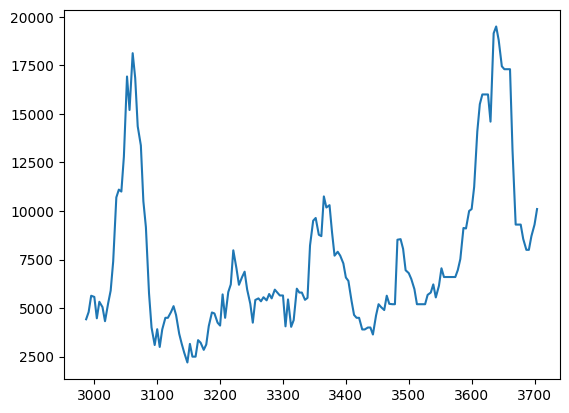

In [49]:
agg_level = 'District'

district_list = UC2_cube.District.attrs['District_Name']

SPEI = UC2_cube[[agg_level, 'SPEI_6M']].to_dataframe().dropna().reset_index().drop(columns=['spatial_ref', 'latitude', 'longitude'])

SPEI = SPEI.set_index('time').groupby('District')['SPEI_6M'].resample('W-MON').mean()

IDP = UC2_cube[[agg_level, 'IDP_Drought']].to_dataframe().dropna().reset_index().drop(columns=['spatial_ref', 'latitude', 'longitude'])

IDP = IDP.set_index('time').groupby('District')['IDP_Drought'].resample('W-MON').sum()

conflict = UC2_cube[[agg_level, 'fatalities']].to_dataframe().dropna().reset_index().drop(columns=['spatial_ref', 'latitude', 'longitude'])

conflict = conflict.set_index('time').groupby('District')[['fatalities']].resample('W-MON').sum()

tabular_market = market_data_geocoded.copy()

# Iterate with same coordinates markets and select the best one (because they are in the same coordinate, town, or very close):

groups = tabular_market.groupby([agg_level])

tabular_dataframe = pd.DataFrame()
ord_enc = OrdinalEncoder()

for district, group in groups:

        this_zone = group.fillna(0)
        zone_markets = np.unique(this_zone.Market)
                
        if len(zone_markets) > 1:
            print(f"{agg_level} {district}:")
            print(zone_markets)
            
            # For each group save the best feature column
            best_market_data = this_zone[this_zone['Market'] == zone_markets[0]][['Date', agg_level]].reset_index(drop=True)

            # Iterate through the features:
            for feature in this_zone.columns[6:]:
                ord_variance = np.array([])
                
                # Iterate through markets
                for market in zone_markets:

                    # Select market and ordinal encode values and then calculate variance
                    check_market = this_zone[this_zone['Market'] == market]
                    market_enc = ord_enc.fit_transform(np.unique(np.array(check_market[feature])).reshape(-1, 1)).astype(int)
                    variance = np.var(market_enc.flatten())
                    ord_variance = np.append(ord_variance, variance)

                # Select the feature that has the maximum variance among markets
                max_index = np.argmax(ord_variance)
                market_best_feature = zone_markets[max_index]


                # Append the best feature to the district data
                best_market_feature = this_zone[(this_zone['Market'] == market_best_feature)][feature].reset_index(drop=True)
                best_market_data = pd.concat([best_market_data, best_market_feature], axis=1)

                print('selected:', feature, 'in', market_best_feature, 'for:', f"Area ({district}):")
            print('-------------------------------------------------')
            # Concatenate district data to the final dataframe
            tabular_dataframe = pd.concat([tabular_dataframe, best_market_data], axis=0).reset_index(drop=True)
        
        else: 
            tabular_dataframe = pd.concat([tabular_dataframe, group], axis=0).reset_index(drop=True)


market_data_clean_tabular = tabular_dataframe.replace(0, np.nan)
market_data_clean_tabular = market_data_clean_tabular.rename(columns={'Date': 'time'})
market_data_clean_tabular= market_data_clean_tabular.set_index(['time']).drop(columns=['Region', 'Market', 'latitude', 'longitude']).groupby('District').resample('W-MON').mean()


def replace_with_district_name(index):
    return district_list[int(index)]

merged_df = pd.DataFrame(IDP).join(SPEI, how='outer').join(conflict, how='outer').reset_index()

merged_df['District'] = merged_df['District'].apply(replace_with_district_name)

merged_df = merged_df.set_index(['District','time']).join(market_data_clean_tabular, how='outer').reset_index()


merged_df[merged_df.District == 'Baidoa']['IDP_Drought'].plot()
plt.show()

merged_df[merged_df.District == 'Baidoa']['fatalities'].plot()
plt.show()

merged_df[merged_df.District == 'Baidoa']['SPEI_6M'].plot()
plt.show()

merged_df[merged_df.District == 'Baidoa']['Red Sorghum Price'].dropna().plot()
plt.show()

merged_df[merged_df.District == 'Baidoa']['Water Drum Price'].dropna().plot()
plt.show()

merged_df.to_csv('UC2_District_aggregation_data.csv')

#### Region

Region ('Awdal',):
['Borama' 'Garbodadar' 'Zeylac']
selected: Red Sorghum Price in Borama for: Area (('Awdal',)):
selected: Wheat Flour Price in Zeylac for: Area (('Awdal',)):
selected: Sugar Price in Borama for: Area (('Awdal',)):
selected: Vegetable Oil Price in Borama for: Area (('Awdal',)):
selected: Camel Milk Price in Zeylac for: Area (('Awdal',)):
selected: Tea Leaves Price in Borama for: Area (('Awdal',)):
selected: Salt Price in Garbodadar for: Area (('Awdal',)):
selected: Cowpeas Price in Borama for: Area (('Awdal',)):
selected: Water Drum Price in Borama for: Area (('Awdal',)):
selected: Cattle Price in Borama for: Area (('Awdal',)):
selected: Camel Price in Borama for: Area (('Awdal',)):
selected: Goat Price in Borama for: Area (('Awdal',)):
selected: SomaliShillingToUSD in Borama for: Area (('Awdal',)):
selected: SomalilandShToUSD in Borama for: Area (('Awdal',)):
-------------------------------------------------
Region ('Bakool',):
['Burdunle' 'Ceel Barde' 'Ceel Garas' 'G

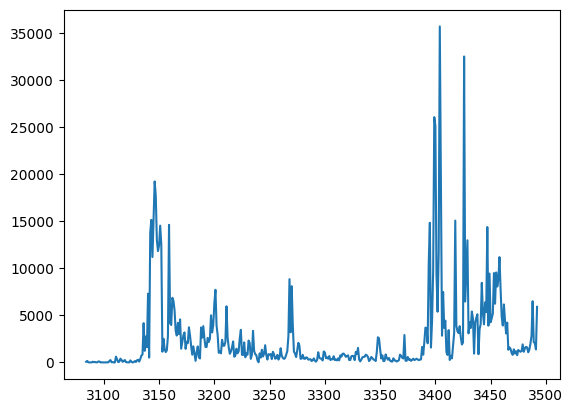

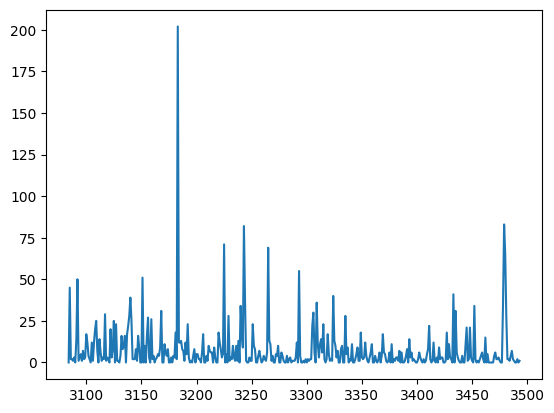

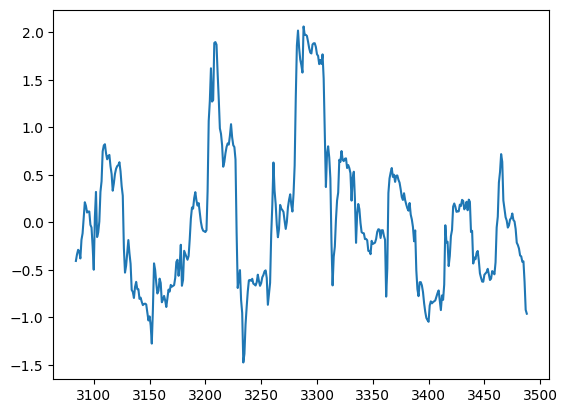

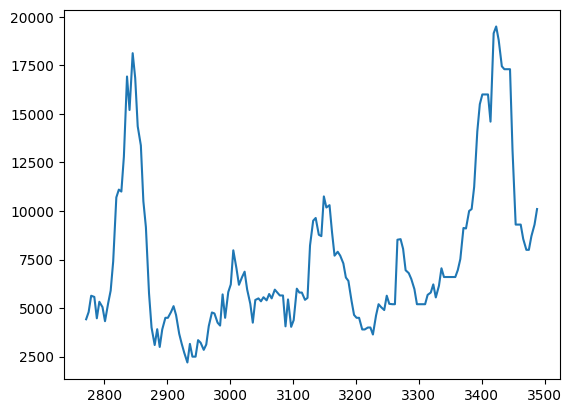

In [51]:
agg_level = 'Region'

district_list = UC2_cube.Region.attrs['Region_Name']

SPEI = UC2_cube[[agg_level, 'SPEI_6M']].to_dataframe().dropna().reset_index().drop(columns=['spatial_ref', 'latitude', 'longitude'])

SPEI = SPEI.set_index('time').groupby(agg_level)['SPEI_6M'].resample('W-MON').mean()

IDP = UC2_cube[[agg_level, 'IDP_Drought']].to_dataframe().dropna().reset_index().drop(columns=['spatial_ref', 'latitude', 'longitude'])

IDP = IDP.set_index('time').groupby(agg_level)['IDP_Drought'].resample('W-MON').sum()

conflict = UC2_cube[[agg_level, 'fatalities']].to_dataframe().dropna().reset_index().drop(columns=['spatial_ref', 'latitude', 'longitude'])

conflict = conflict.set_index('time').groupby(agg_level)[['fatalities']].resample('W-MON').sum()

tabular_market = market_data_geocoded.copy()

# Iterate with same coordinates markets and select the best one (because they are in the same coordinate, town, or very close):

groups = tabular_market.groupby([agg_level])

tabular_dataframe = pd.DataFrame()
ord_enc = OrdinalEncoder()

for district, group in groups:

        this_zone = group.fillna(0)
        zone_markets = np.unique(this_zone.Market)
                
        if len(zone_markets) > 1:
            print(f"{agg_level} {district}:")
            print(zone_markets)
            
            # For each group save the best feature column
            best_market_data = this_zone[this_zone['Market'] == zone_markets[0]][['Date', agg_level]].reset_index(drop=True)

            # Iterate through the features:
            for feature in this_zone.columns[6:]:
                ord_variance = np.array([])
                
                # Iterate through markets
                for market in zone_markets:

                    # Select market and ordinal encode values and then calculate variance
                    check_market = this_zone[this_zone['Market'] == market]
                    market_enc = ord_enc.fit_transform(np.unique(np.array(check_market[feature])).reshape(-1, 1)).astype(int)
                    variance = np.var(market_enc.flatten())
                    ord_variance = np.append(ord_variance, variance)

                # Select the feature that has the maximum variance among markets
                max_index = np.argmax(ord_variance)
                market_best_feature = zone_markets[max_index]


                # Append the best feature to the district data
                best_market_feature = this_zone[(this_zone['Market'] == market_best_feature)][feature].reset_index(drop=True)
                best_market_data = pd.concat([best_market_data, best_market_feature], axis=1)

                print('selected:', feature, 'in', market_best_feature, 'for:', f"Area ({district}):")
            print('-------------------------------------------------')
            # Concatenate district data to the final dataframe
            tabular_dataframe = pd.concat([tabular_dataframe, best_market_data], axis=0).reset_index(drop=True)
        
        else: 
            tabular_dataframe = pd.concat([tabular_dataframe, group], axis=0).reset_index(drop=True)


market_data_clean_tabular = tabular_dataframe.replace(0, np.nan)
market_data_clean_tabular = market_data_clean_tabular.rename(columns={'Date': 'time'})
market_data_clean_tabular= market_data_clean_tabular.set_index(['time']).groupby(agg_level).resample('W-MON').mean()


def replace_with_district_name(index):
    return district_list[int(index)]

merged_df = pd.DataFrame(IDP).join(SPEI, how='outer').join(conflict, how='outer').reset_index()

merged_df[agg_level] = merged_df[agg_level].apply(replace_with_district_name)

merged_df = merged_df.set_index([agg_level,'time']).join(market_data_clean_tabular, how='outer').reset_index()


merged_df[merged_df[agg_level] == 'Bay']['IDP_Drought'].plot()
plt.show()

merged_df[merged_df[agg_level] == 'Bay']['fatalities'].plot()
plt.show()

merged_df[merged_df[agg_level] == 'Bay']['SPEI_6M'].plot()
plt.show()

merged_df[merged_df[agg_level] == 'Bay']['Red Sorghum Price'].dropna().plot()
plt.show()

merged_df.to_csv('UC2_Region_aggregation_data.csv')

# Check if everything is alright

In [2]:

UC2_cube = xr.open_dataset('UC2_public_cube.nc')

crs_projection = 'epsg:4326'  # Assuming WGS84 coordinate system
UC2_cube.rio.write_crs(crs_projection, inplace=True)
UC2_cube


<xarray.Dataset> Size: 12GB
Dimensions:              (latitude: 178, longitude: 137, time: 2866)
Coordinates:
  * latitude             (latitude) float32 712B -1.6 -1.5 -1.4 ... 11.9 12.0
  * longitude            (longitude) float32 548B 41.0 41.1 41.2 ... 51.2 51.3
  * time                 (time) datetime64[ns] 23kB 2016-01-01 ... 2023-11-05
    spatial_ref          int32 4B 0
Data variables: (12/29)
    Livelihood           (latitude, longitude) float64 195kB ...
    Region               (latitude, longitude) float64 195kB ...
    District             (latitude, longitude) float64 195kB ...
    t2m                  (latitude, longitude, time) float32 280MB ...
    pev                  (latitude, longitude, time) float32 280MB ...
    swvl1                (latitude, longitude, time) float32 280MB ...
    ...                   ...
    Water Drum Price     (latitude, longitude, time) float64 559MB ...
    Cattle Price         (latitude, longitude, time) float64 559MB ...
    Camel Price          (latitude, longitude, time) float64 559MB ...
    Goat Price           (latitude, longitude, time) float64 559MB ...
    SomaliShillingToUSD  (latitude, longitude, time) float64 559MB ...
    SomalilandShToUSD    (latitude, longitude, time) float64 559MB ...

In [10]:
UC2_cube

<xarray.DataArray 'SPEI_6M' (latitude: 136, longitude: 104, time: 2706)>
[38273664 values with dtype=float64]
Coordinates:
    spatial_ref  int32 0
  * latitude     (latitude) float32 -1.6 -1.5 -1.4 -1.3 ... 11.6 11.7 11.8 11.9
  * longitude    (longitude) float32 41.0 41.1 41.2 41.3 ... 51.0 51.1 51.2 51.3
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-05-29
Attributes:
    units:               
    calibration_period:  ['2000-01-01T00:00:00', '2023-05-29T00:00:00']

In [12]:
UC2_cube = UC2_cube[['SPEI_6M', 'Livelihood']]

vars_list = list(UC2_cube.data_vars)  
for var in vars_list:  
    if 'grid_mapping' in UC2_cube[var].attrs:
        del UC2_cube[var].attrs['grid_mapping']

UC2_cube.to_netcdf('SPEI_Somalia_Cube.nc')

In [5]:
UC2_cube['SPEI_6M']

<xarray.DataArray 'SPEI_6M' (latitude: 136, longitude: 104, time: 2706)>
[38273664 values with dtype=float64]
Coordinates:
    spatial_ref  int32 0
  * latitude     (latitude) float32 -1.6 -1.5 -1.4 -1.3 ... 11.6 11.7 11.8 11.9
  * longitude    (longitude) float32 41.0 41.1 41.2 41.3 ... 51.0 51.1 51.2 51.3
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-05-29
Attributes:
    units:               
    calibration_period:  ['2000-01-01T00:00:00', '2023-05-29T00:00:00']
    grid_mapping:        spatial_ref

<Axes: xlabel='Date'>

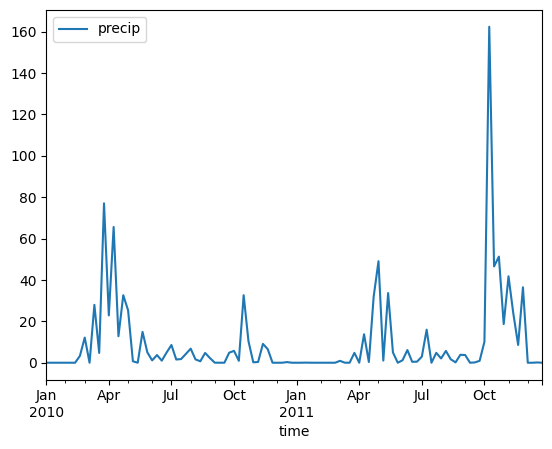

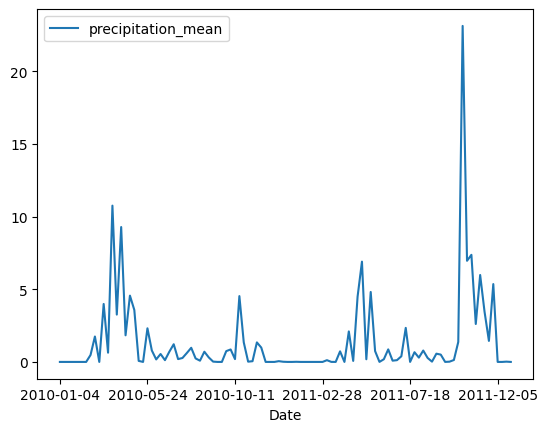

In [20]:
#%% Check aggregated CHIRPS in Baidoa: works

# Select Baidoa
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

# temporal sum:
filtered_data = filtered_data.precip.to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] == 2010) | (filtered_data['Year'] == 2011)].plot(x = 'time', y='precip')


#%% Check old CHIRPS
check_chirps = pd.read_csv('Somalia_District_Dataset_newMarket2.csv')

baidoa_chirps = check_chirps[['District', 'Date', 'precipitation_mean']][check_chirps.District == 'Baidoa']

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_chirps['Year'] = pd.to_datetime(baidoa_chirps['Date']).dt.year

# Filter the DataFrame for the year 2010
baidoa_chirps[(baidoa_chirps['Year'] == 2010) | (baidoa_chirps['Year'] == 2011)].plot(x = 'Date', y='precipitation_mean')


In [ ]:
#%% Check aggregated CHIRPS in Baidoa: works

# Select Baidoa
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

# temporal sum:
filtered_data = filtered_data.precip.to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] == 2010) | (filtered_data['Year'] == 2011)].plot(x = 'time', y='precip')



NameError: name 'PRMN_data_IDP' is not defined

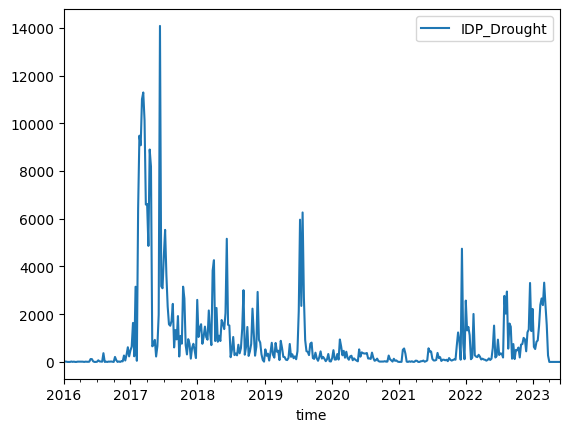

In [6]:
#%% Check aggregated IDP in Baidoa: works

# Select Baidoa (faster if we use a mask and the command .sel)
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

filtered_data = filtered_data['IDP_Drought'].to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] >= 2016)].plot(x = 'time', y='IDP_Drought')


#%% Check PRMN

baidoa_PRMN_data_IDP = PRMN_data_IDP[['District', 'time', 'IDP_Drought']][PRMN_data_IDP.District == 5]

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_PRMN_data_IDP['Year'] = pd.to_datetime(baidoa_PRMN_data_IDP['time']).dt.year

# Filter the DataFrame for the year 2010
baidoa_PRMN_data_IDP[(baidoa_PRMN_data_IDP['Year'] >= 2016)].fillna(0).plot(x = 'time', y='IDP_Drought')


NameError: name 'market_data_best' is not defined

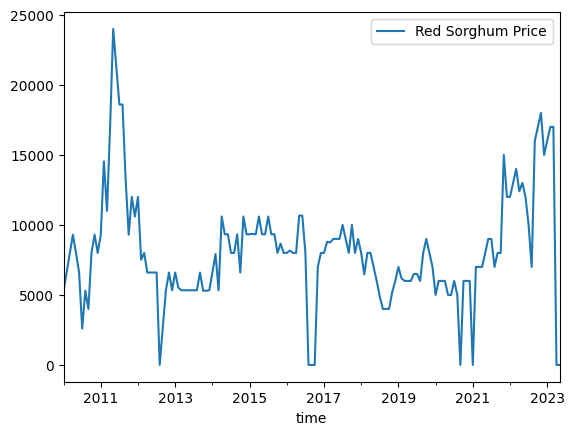

In [7]:
#%% Check Market in Baidoa: works

# Select Baidoa (faster if we use a mask and the command .sel)
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

filtered_data = filtered_data['Red Sorghum Price'].to_dataframe().reset_index().resample('M', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] >= 2010)].interpolate().plot(x = 'time', y='Red Sorghum Price')

#%% Check FSNAU
baidoa_market_data_best = market_data_best[['District', 'time', 'Red Sorghum Price']][market_data_best.District == 5]

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_market_data_best['Year'] = pd.to_datetime(baidoa_market_data_best['time']).dt.year

# Filter the DataFrame for the year 2010
baidoa_market_data_best[(baidoa_market_data_best['Year'] >= 2010)].fillna(0).plot(x = 'time', y='Red Sorghum Price')


<Axes: xlabel='Date'>

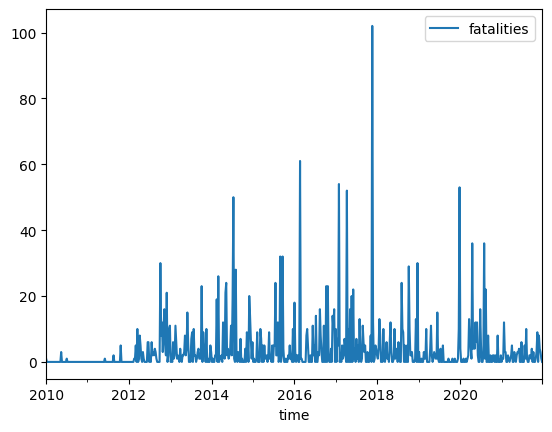

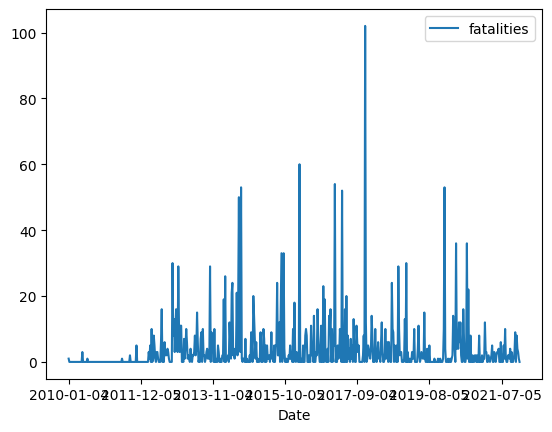

In [39]:
#%% Check aggregated ACLED in Baidoa: works

# Select Baidoa
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial sum in the district
filtered_data = filtered_data.sum(dim=('latitude', 'longitude'))

# temporal sum:
filtered_data = filtered_data.fatalities.to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] >= 2010) & (filtered_data['Year'] < 2022)].fillna(0).plot(x = 'time', y='fatalities')


#%% Check old ACLED
check_acled = pd.read_csv('Somalia_District_Dataset_newMarket2.csv')

baidoa_acled = check_acled[['District', 'Date', 'fatalities']][check_acled.District == 'Baidoa']

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_acled['Year'] = pd.to_datetime(baidoa_acled['Date']).dt.year

# Filter the DataFrame for the year 2010
baidoa_acled[(baidoa_acled['Year'] >= 2010) & (baidoa_acled['Year'] < 2022)].fillna(0).plot(x = 'Date', y='fatalities')


# Climate Indexes

In [8]:
#%% Extract precipitation in Baidoa only in croplands

lc_names = UC2_cube.lccs_class.flag_meanings.split(' ') 
print(np.array(lc_names)[[1,2,3,4,5]])

lc_values = UC2_cube.lccs_class.flag_values[[1,2,3,4,5]]

#%% Check aggregated CHIRPS in Baidoa: works

# Select Baidoa
lc_mask = UC2_cube.where((UC2_cube['District'] == 5), drop=True).where(UC2_cube['lccs_class'].isin(lc_values), drop=True)
# Get the indices of True values in lc_mask



['cropland_rainfed' 'cropland_rainfed_herbaceous_cover'
 'cropland_rainfed_tree_or_shrub_cover' 'cropland_irrigated'
 'mosaic_cropland']


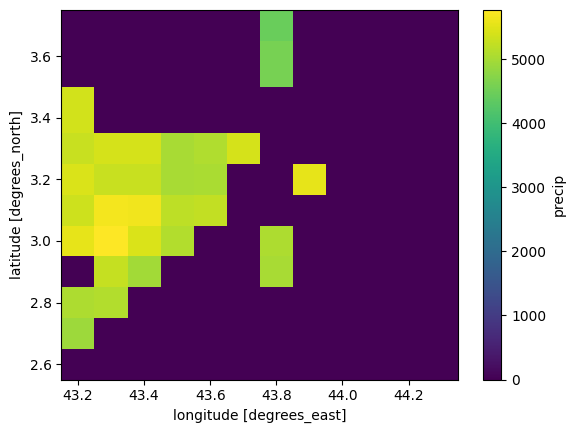

In [9]:
lc_mask.precip.sum(dim='time').plot()

<Axes: xlabel='Date'>

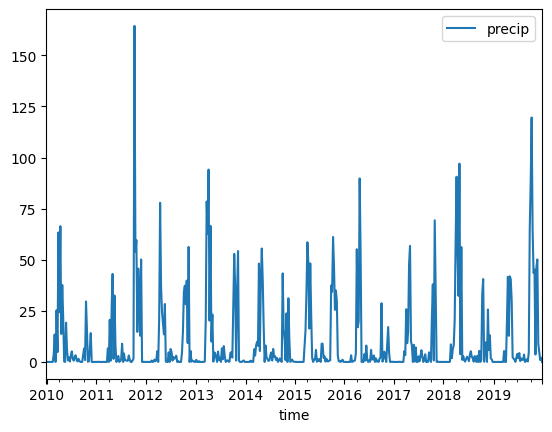

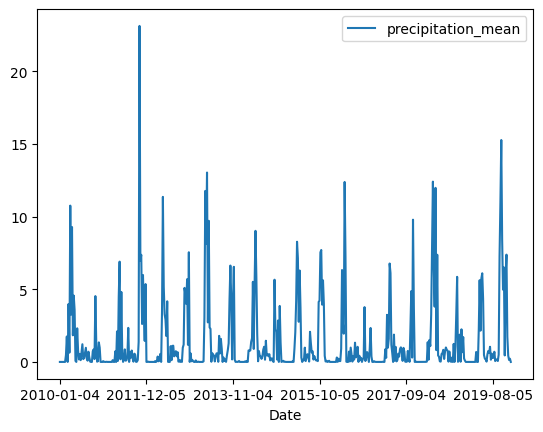

In [58]:
lc_mask.precip.mean(dim=['latitude', 'longitude']).to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().plot()


#%% Check old CHIRPS
check_chirps = pd.read_csv('Somalia_District_Dataset_newMarket2.csv')

baidoa_chirps = check_chirps[['District', 'Date', 'precipitation_mean']][check_chirps.District == 'Baidoa']

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_chirps['Year'] = pd.to_datetime(baidoa_chirps['Date']).dt.year

# Filter the DataFrame for the year 2010
baidoa_chirps[(baidoa_chirps['Year']>=2010) & (baidoa_chirps['Year']<2020) ].dropna().plot(x = 'Date', y='precipitation_mean')


# Aggregate Somalia LandCover


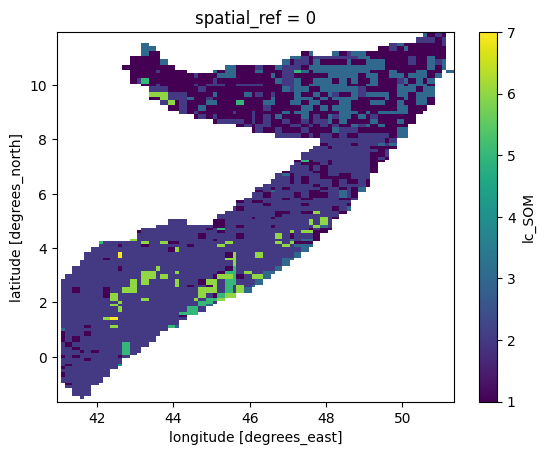

In [51]:

# Works great if reading shapefile set from disk directly:

Land_cover_SOM = gpd.read_file("SOM_landcover.zip")

#%% Add district shapefile

Land_cover_SOM = Land_cover_SOM[['GRIDCODE', 'LCS3uslb', 'geometry']].rename(columns={'GRIDCODE': 'lc_SOM'})


lc_geom = Land_cover_SOM.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
lc_geom = make_geocube(vector_data=lc_geom, resolution=(0.1, -0.1), fill=np.NaN)

lc_geom = lc_geom.rename({'y': 'latitude', 'x': 'longitude'})

# Resample lc mode to district cube

# lc_geom['lc_SOM'] = lc_geom.lc_SOM.rio.reproject_match(UC2_cube.t2m, rasterio.enums.Resampling.mode)

lc_geom = lc_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude, method='nearest')

# Assign the lc names as an attribute to the "lc" variable
lc_geom['lc_SOM'].attrs['Land_Cover_Name'] = list(set(Land_cover_SOM.LCS3uslb.to_list()))

lc_geom['lc_SOM'].plot()


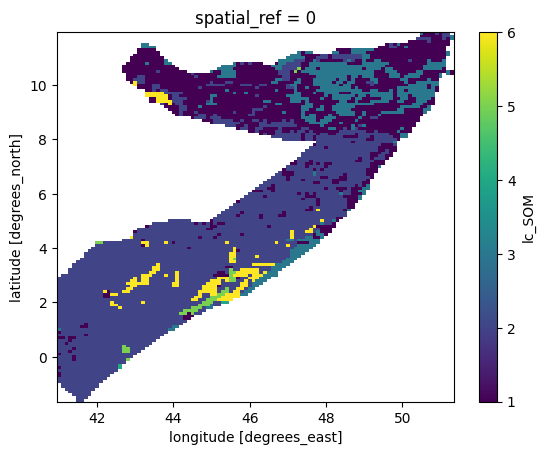

In [52]:

# Works great if reading shapefile set from disk directly:

Land_cover_SOM = gpd.read_file("SOM_landcover.zip")

#%% Add district shapefile

Land_cover_SOM = Land_cover_SOM[['GRIDCODE', 'LCS3uslb', 'geometry']].rename(columns={'GRIDCODE': 'lc_SOM'})


lc_geom = Land_cover_SOM.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
lc_geom = make_geocube(vector_data=lc_geom, resolution=(0.1, -0.1), fill=np.NaN)

lc_geom = lc_geom.rename({'y': 'latitude', 'x': 'longitude'})

# Resample lc mode to district cube

lc_geom['lc_SOM'] = lc_geom.lc_SOM.rio.reproject_match(UC2_cube.t2m, rasterio.enums.Resampling.mode)

# lc_geom = lc_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude, method='nearest')

# Assign the lc names as an attribute to the "lc" variable
lc_geom['lc_SOM'].attrs['Land_Cover_Label'] = list(set(Land_cover_SOM.LCS3uslb.to_list()))

lc_geom['lc_SOM'].attrs['Land_Cover_Label'] = ['Water Bodies', 'Bare Areas', 'Built Up Areas', 'Irrigated Crop', 'Rainfed Crop', 'Natural Woody Vegetation Closed to Open', 'Natural Woody Vegetation Sparse or Herbaceous']

lc_geom['lc_SOM'].plot()


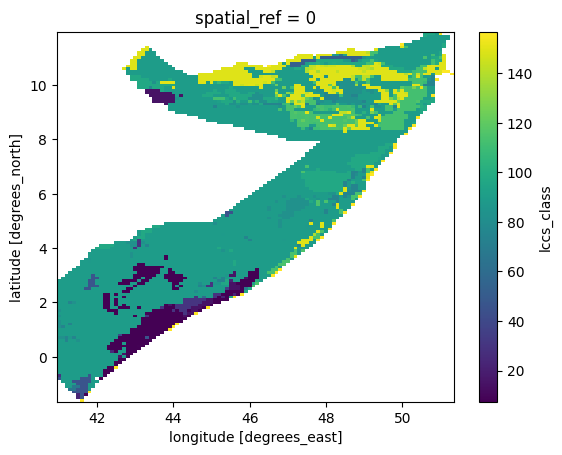

In [58]:

UC2_cube['lccs_class'].mean(dim='time').plot()


In [50]:

lc_geom['lc_SOM'].attrs['Land_Cover_Name']


['WB', 'BA', 'BU', 'IC', 'RC', 'NVCO', 'NVSH']

In [ ]:
# Merge by lat/lon
UC2_cube = xr.merge([district_geom, UC2_cube])

UC2_cube.District.plot()

# LC Change-Copernicus

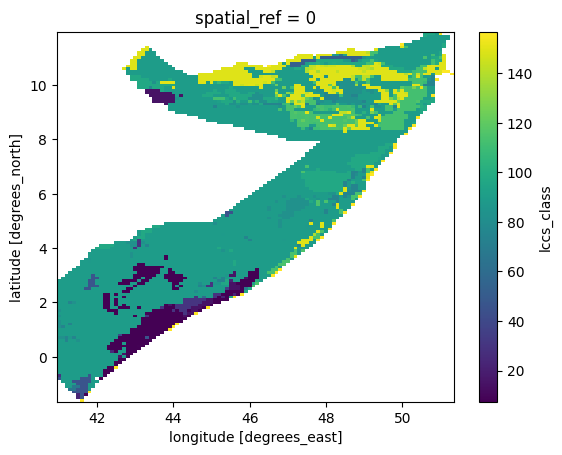

In [56]:

UC2_cube['lccs_class'].mean(dim='time').plot()

In [59]:
UC2_cube

<xarray.Dataset>
Dimensions:              (latitude: 136, longitude: 104, time: 4901)
Coordinates:
  * latitude             (latitude) float32 -1.6 -1.5 -1.4 ... 11.7 11.8 11.9
  * longitude            (longitude) float32 41.0 41.1 41.2 ... 51.1 51.2 51.3
  * time                 (time) datetime64[ns] 2010-01-01 ... 2023-06-02
    spatial_ref          int32 0
Data variables: (12/27)
    Livelihood           (latitude, longitude) float64 ...
    Region               (latitude, longitude) float64 ...
    District             (latitude, longitude) float64 ...
    t2m                  (latitude, longitude, time) float32 ...
    pev                  (latitude, longitude, time) float32 ...
    tp                   (latitude, longitude, time) float32 ...
    ...                   ...
    Salt Price           (latitude, longitude, time) float64 ...
    Cowpeas Price        (latitude, longitude, time) float64 ...
    Water Drum Price     (latitude, longitude, time) float64 ...
    Cattle Price         (latitude, longitude, time) float64 ...
    Camel Price          (latitude, longitude, time) float64 ...
    Goat Price           (latitude, longitude, time) float64 ...

In [63]:
year_1 = UC2_cube.lccs_class.sel(time='2010-01-01')

year_2 = UC2_cube.lccs_class.sel(time='2020-01-01')



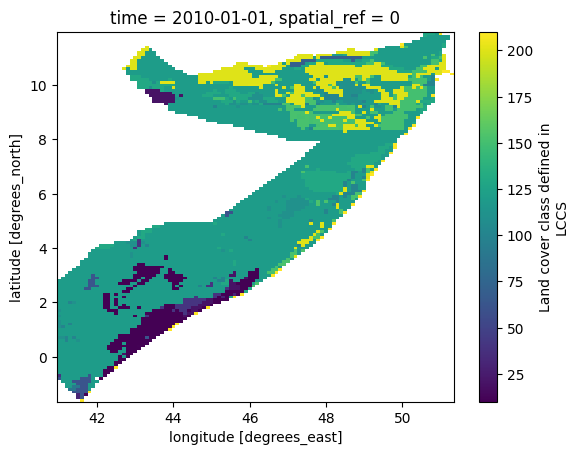

In [67]:
year_1.plot()

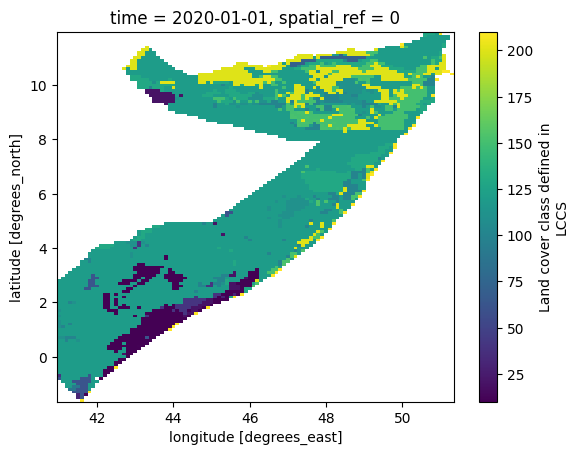

In [66]:
year_2.plot()

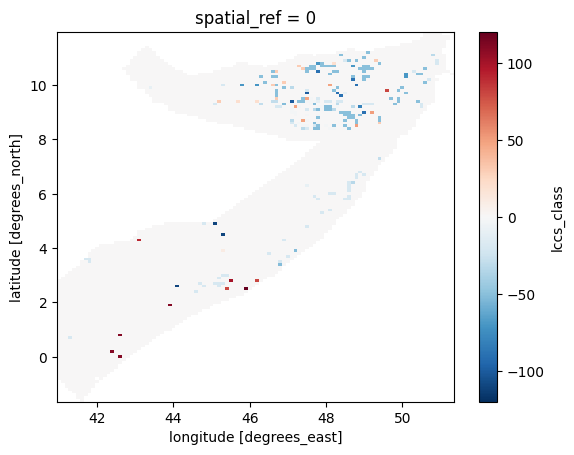

In [69]:
# No landcover change in Baidoa, at least not relevant

(year_2 - year_1).plot()
